In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

EJERCICIO 1

In [ ]:
def impulsivo(val0,prob0,val1,prob1,val2,size):
    arr = np.zeros(size)
    n_ib = cv.randu(arr,0,1)
    for i in np.arange(size[0]):
        for j in np.arange(size[1]):
            if n_ib[i,j] <=prob0:
                n_ib[i,j] = val0
            elif n_ib[i,j]>prob0 and n_ib[i,j]<prob0+prob1:
                n_ib[i,j] = val1
            else:
                n_ib[i,j] = val2
    return n_ib

def mse(imageA, imageB): 
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2) 
    err /= float(imageA.shape[0] * imageA.shape[1]) 
    return err

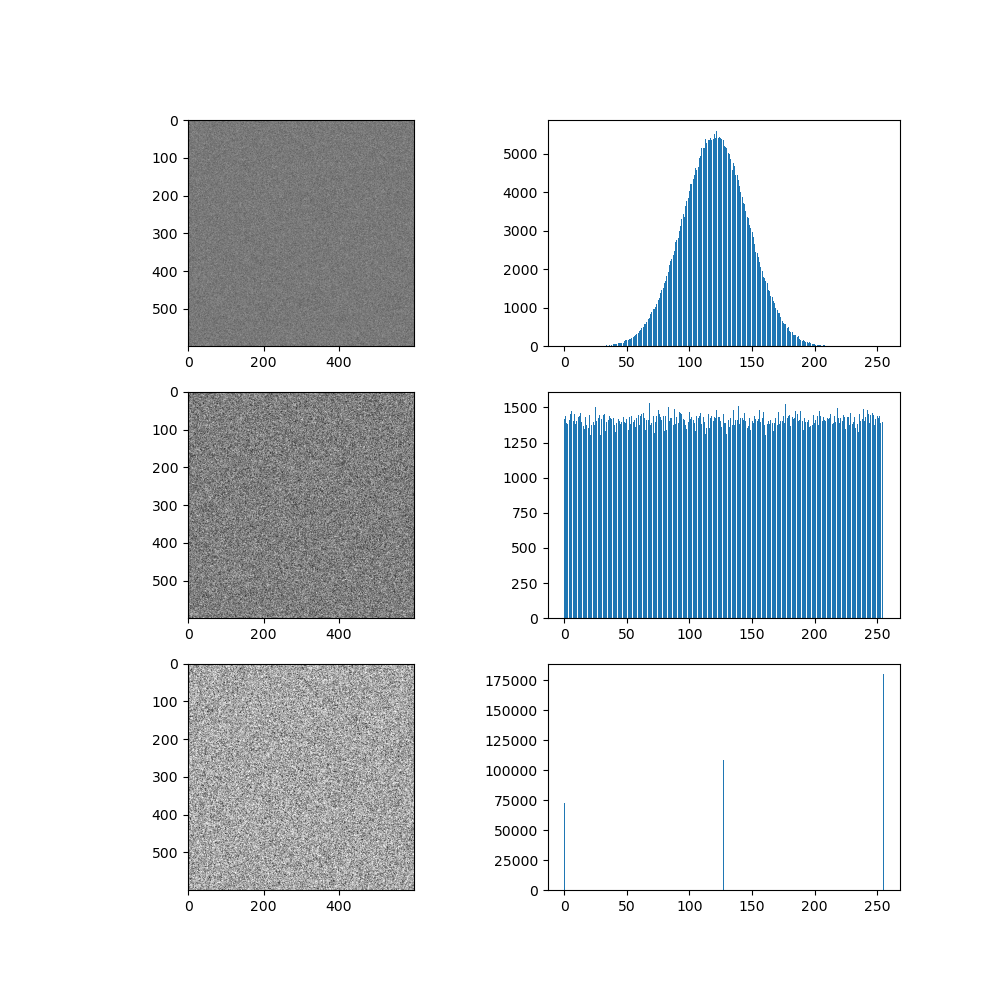

In [118]:
#gaussian noise
im0 = np.zeros((600,600))
n_g = cv.randn(np.copy(im0),100,10)
n_g_n = np.uint8(cv.normalize(np.copy(n_g),np.copy(n_g), 0, 255, cv.NORM_MINMAX))

#uniform noise
n_u = cv.randu(np.copy(im0),-5,5)
n_u_n = np.uint8(cv.normalize(np.copy(n_u),np.copy(n_u), 0, 255, cv.NORM_MINMAX))

#salt and pepper
n_sp = impulsivo(0,.2,255,.5,127,im0.shape)

#histograms
hist_n_g_n = cv.calcHist([n_g_n], [0], None, [256], [0,256])
hist_n_u_n = cv.calcHist([n_u_n], [0], None, [256], [0,256])
hist_n_sp = cv.calcHist([np.uint8(n_sp)], [0], None, [256], [0,256])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10)) 
ax[0,1].bar(range(256),np.squeeze(hist_n_g_n))
ax[0,0].imshow(n_g_n,cmap='gray',vmin=0,vmax=255)

ax[1,1].bar(range(256),np.squeeze(hist_n_u_n))
ax[1,0].imshow(n_u_n,cmap='gray',vmin=0,vmax=255)

ax[2,1].bar(range(256),np.squeeze(hist_n_sp))
ax[2,0].imshow(n_sp,cmap='gray',vmin=0,vmax=255)
plt.show()

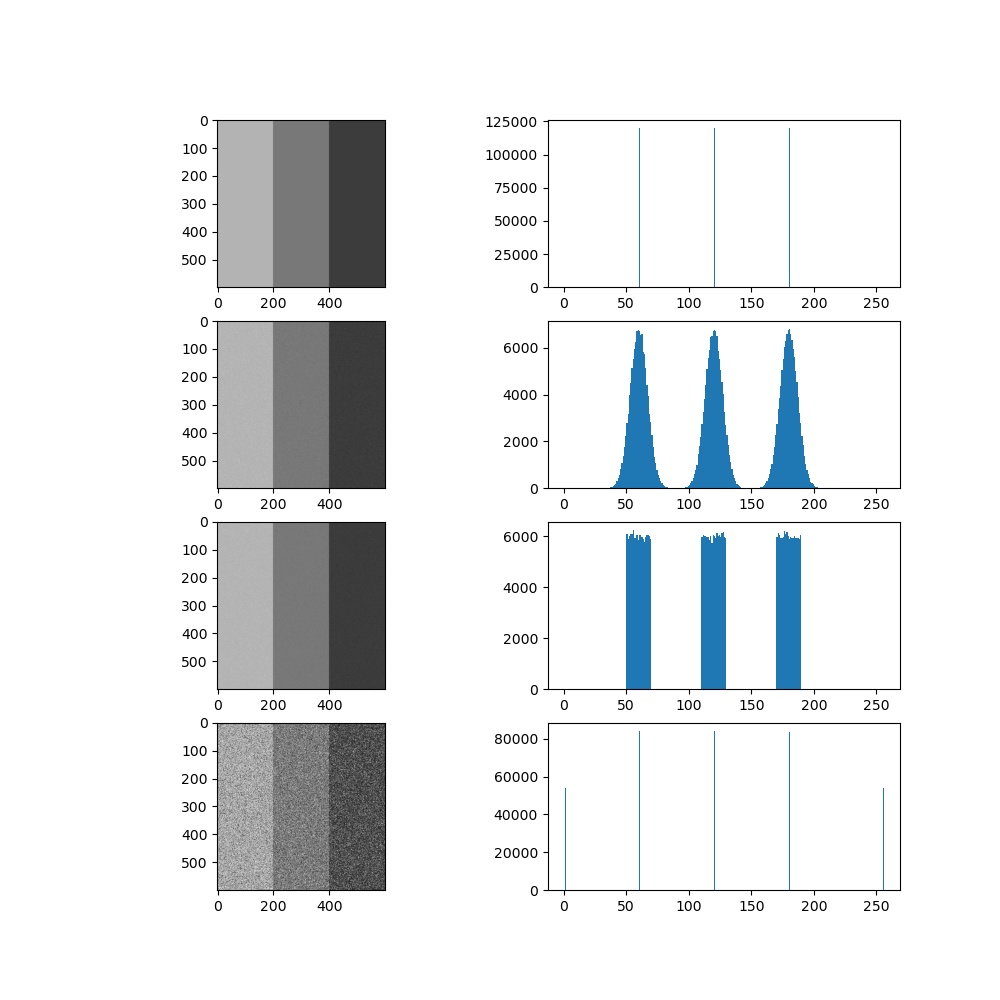

In [125]:
im1 = np.zeros((600,600))
im1[:,0:200] = 180
im1[:,200:400] = 120
im1[:,400:600] = 60

#noising
im1_n_g_n = im1 + np.random.normal(0, 7, (im1.shape[0],im1.shape[1]))
im1_n_u_n = im1 + np.random.uniform(-10,10, (im1.shape[0],im1.shape[1]))
n_i = impulsivo(1,.15,255,.15,0,im1.shape)
im1_n_sp = np.where(n_i > 0, n_i, im1)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(im1,cmap='gray',vmin=0,vmax=255)
ax[0,1].hist(im1.ravel(),256,[0,256])

ax[1,0].imshow(im1_n_g_n,cmap='gray',vmin=0,vmax=255)
ax[1,1].hist(im1_n_g_n.ravel(),256,[0,256])

ax[2,0].imshow(im1_n_u_n,cmap='gray',vmin=0,vmax=255)
ax[2,1].hist(im1_n_u_n.ravel(),256,[0,256])

ax[3,0].imshow(im1_n_sp,cmap='gray',vmin=0,vmax=255)
ax[3,1].hist(im1_n_sp.ravel(),256,[0,256])
plt.show()

EJERCICIO 2

In [130]:
def geometric_mean_filter(image, filter_size):
    # Obtener el tamaño de la imagen
    im_H, im_W = image.shape
    #aplica filtro media geométrica, im -> im_f_mg
    filter_size = 3
    padsize = (filter_size-1)//2
    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,1).astype(np.float64)

    im_f_mg = np.zeros(image.shape)

    for i in range(im_H):
        for j in range(im_W):
            im_f_mg[i, j] = np.prod(im_p[i:i+filter_size,j:j+filter_size])**(1/(filter_size**2))

    return im_f_mg

def contrarmonic_filter(image, ksize,Q):

    # Obtener el tamaño de la imagen
    im_H, im_W = image.shape

    ksize = 3
    padsize = (ksize-1)//2
    im_p = cv.copyMakeBorder(np.copy(image), *[padsize]*4, cv.BORDER_CONSTANT,0).astype(np.float64)

    im_f_mch = np.zeros(image.shape)
    for i in range(im_H):
        for j in range(im_W):
            im_f_mch[i, j] = np.sum(im_p[i:i+ksize,j:j+ksize]**(Q+1))/(np.sum(im_p[i:i+ksize,j:j+ksize]**Q))

    return im_f_mch

MSE Degradada (Gauss) - Limpia:  384.37822916666664
MSE Filtrada (GeoMean) - Limpia:  298.3603018395367


MSE Degradada (Imp) - Limpia:  1357.6406125
MSE Filtrada (ContArm) - Limpia:  838.5841534833647


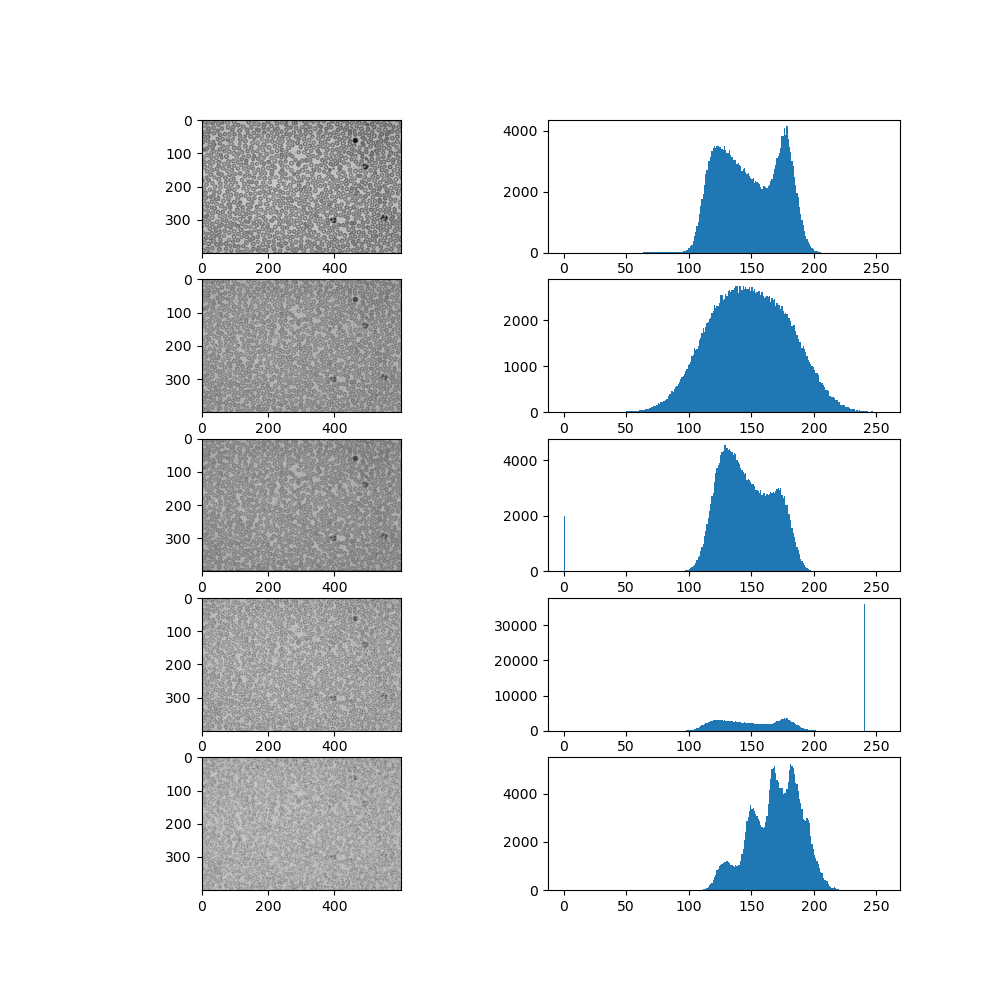

In [144]:
sangre = cv.imread('imagenes/sangre.jpg', cv.IMREAD_GRAYSCALE)

gaussian = np.random.normal(0, 20, (sangre.shape[0],sangre.shape[1])).astype(np.uint8)
imp_noise = impulsivo(50,0,240,0.15,0,sangre.shape).astype(np.uint8)

sangre_noise_g = sangre+gaussian
sangre_noise_imp = np.where(imp_noise > 0,imp_noise,sangre)

sangre_filtrada = geometric_mean_filter(sangre_noise_g,3)

sangre_filtrada_2 = contrarmonic_filter(sangre_noise_imp,3,1)

print("MSE Degradada (Gauss) - Limpia: ",mse(sangre,sangre_noise_g))
print("MSE Filtrada (GeoMean) - Limpia: ",mse(sangre,sangre_filtrada))
print("\n")
print("MSE Degradada (Imp) - Limpia: ",mse(sangre,sangre_noise_imp))
print("MSE Filtrada (ContArm) - Limpia: ",mse(sangre,sangre_filtrada_2))

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10)) 
ax[0,0].imshow(sangre,cmap='gray')
ax[0,1].hist(sangre.ravel(),256,[0,256])

ax[1,0].imshow(sangre_noise_g,cmap='gray',vmin=0,vmax=255)
ax[1,1].hist(sangre_noise_g.ravel(),256,[0,256])

ax[2,0].imshow(sangre_filtrada,cmap='gray',vmin=0,vmax=255)
ax[2,1].hist(sangre_filtrada.ravel(),256,[0,256])

ax[3,0].imshow(sangre_noise_imp,cmap='gray',vmin=0,vmax=255)
ax[3,1].hist(sangre_noise_imp.ravel(),256,[0,256])

ax[4,0].imshow(sangre_filtrada_2,cmap='gray',vmin=0,vmax=255)
ax[4,1].hist(sangre_filtrada_2.ravel(),256,[0,256])
plt.show()
